# 네일아트 시뮬레이션 프로그램 만들기

> YouTube [빵형의 개발도상국](https://www.youtube.com/@bbanghyong)

> 부록: [Segment Anything 2 Demo](https://sam2.metademolab.com/demo)

## PaddlePaddle

- 바이두에서 개발한 오픈소스 딥러닝 플랫폼입니다.
- 다양한 AI 애플리케이션 개발을 위한 도구와 라이브러리를 제공합니다.
- 컴퓨터 비전, 자연어 처리, 추천 시스템 등 여러 분야에 활용됩니다.

## PaddleSeg

- PaddlePaddle 생태계의 일부로, 이미지 세그멘테이션에 특화된 도구입니다.
- 다양한 세그멘테이션 모델과 데이터셋을 지원합니다.
- 의료 영상, 자율 주행, 위성 이미지 분석 등에 활용될 수 있습니다.

> Reference: https://aistudio.baidu.com/projectdetail/5156312

In [1]:
!pip install -qU paddlepaddle-gpu
!git clone --branch release/2.8 --depth 1 https://gitee.com/PaddlePaddle/PaddleSeg.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.9/758.9 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.5 MB/s eta 0:00:00
Cloning into 'PaddleSeg'...
remote: Enumerating objects: 3047, done.
remote: Counting objects: 100% (3047/3047), done.
remote: Compressing objects: 100% (2245/2245), done.
remote: Total 3047 (delta 926), reused 2154 (delta 676), pack-reused 0
Receiving objects: 100% (3047/3047), 51.11 MiB | 786.00 KiB/s, done.
Resolving deltas: 100% (926/926), done.


## Dataset

[Nails Segmentation](https://www.kaggle.com/datasets/vpapenko/nails-segmentation)

![](https://storage.googleapis.com/kaggle-datasets-images/257642/540765/e6a44acc8cc07c4c999df01ab8d502d8/dataset-cover.png?t=2019-07-08-12-00-40)

In [2]:
%cd /content
!wget -q https://github.com/kairess/toy-datasets/raw/master/Nails.zip
!unzip -q Nails.zip

/content


## Split Dataset

In [3]:
!python /content/PaddleSeg/tools/data/split_dataset_list.py /content/Nails images labels --format jpg jpg

Creating train.txt...
images/9ABD7CB9-7617-4A66-8892-B335FDB0E89F.jpg labels/9ABD7CB9-7617-4A66-8892-B335FDB0E89F.jpg

images/5CBCC5AC-B638-4DFA-AA7B-2464FADFF2F7.jpg labels/5CBCC5AC-B638-4DFA-AA7B-2464FADFF2F7.jpg

images/d633f320-db67-11e8-9658-0242ac1c0002.jpg labels/d633f320-db67-11e8-9658-0242ac1c0002.jpg

images/2C29D473-CCB4-458C-926B-99D0042161E6.jpg labels/2C29D473-CCB4-458C-926B-99D0042161E6.jpg

images/F6F9B3E6-FA7B-4DAC-B08C-1AD19BC43A76.jpg labels/F6F9B3E6-FA7B-4DAC-B08C-1AD19BC43A76.jpg

images/41d83dbb-7c39-4d91-979e-eec5ff71b265.jpg labels/41d83dbb-7c39-4d91-979e-eec5ff71b265.jpg

images/4c49b502-e402-11e8-97db-0242ac1c0002.jpg labels/4c49b502-e402-11e8-97db-0242ac1c0002.jpg

images/869CDA2E-8251-4880-89D6-9409CBC416F3.jpg labels/869CDA2E-8251-4880-89D6-9409CBC416F3.jpg

images/964c11f9-fbe3-420e-8674-9bb356cb5d3f.jpg labels/964c11f9-fbe3-420e-8674-9bb356cb5d3f.jpg

images/865a1e90-7ad2-4ceb-b2a1-50b07875c5c7.jpg labels/865a1e90-7ad2-4ceb-b2a1-50b07875c5c7.jpg

images/4

## Add a 'transforms' Component

In [4]:
grayscale_component = '''
@manager.TRANSFORMS.add_component
class Grayscale:
    def __init__(self):
        pass

    def __call__(self, data):
        """
        Args:
            data (dict): A dict that must include the key 'img'.

        Returns:
            dict: The transformed data with the grayscale image.
        """
        if 'label' not in data:
            raise ValueError("`data` must include `label` key.")

        img = data['label']

        if isinstance(img, np.ndarray):
            if img.ndim == 3 and img.shape[2] == 3:  # Check if image is RGB
                gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                data['label'] = gray_img.astype(np.float32) / 255.
            else:
                raise ValueError("Expected image with 3 channels (RGB), got shape {}".format(img.shape))
        else:
            raise TypeError("Expected numpy array, got {}".format(type(img)))

        return data

'''

with open("/content/PaddleSeg/paddleseg/transforms/transforms.py", "a") as f:
    f.write(grayscale_component)

## Training Config

PP-LiteSeg: A Superior Real-Time Semantic Segmentation Model

Review: https://kimjy99.github.io/%EB%85%BC%EB%AC%B8%EB%A6%AC%EB%B7%B0/pp-liteseg/

In [5]:
%%writefile /content/myconfig.yaml
batch_size: 8
iters: 5000

train_dataset:
  type: Dataset
  dataset_root: /content/Nails
  train_path: /content/Nails/train.txt
  num_classes: 2
  mode: train
  transforms:
    - type: RandomPaddingCrop
      crop_size: [480, 360]
    - type: Resize
      target_size: [480, 360]
    - type: RandomHorizontalFlip
    - type: RandomDistort
      brightness_range: 0.5
      contrast_range: 0.5
      saturation_range: 0.5
    - type: Grayscale
    - type: Normalize

val_dataset:
  type: Dataset
  dataset_root: /content/Nails
  val_path: /content/Nails/val.txt
  num_classes: 2
  mode: val
  transforms:
    - type: Grayscale
    - type: Normalize

optimizer:
  type: sgd
  momentum: 0.9
  weight_decay: 4.0e-5

lr_scheduler:
  type: PolynomialDecay
  learning_rate: 0.01
  end_lr: 0
  power: 0.9

loss:
  types:
    - type: CrossEntropyLoss
  coef: [1, 1, 1]


model:
  type: PPLiteSeg
  backbone:
    type: STDC2
    pretrained: https://bj.bcebos.com/paddleseg/dygraph/PP_STDCNet2.tar.gz

Writing /content/myconfig.yaml


## Train

In [6]:
!cp /content/PaddleSeg/tools/train.py /content/PaddleSeg

!python /content/PaddleSeg/train.py \
    --config /content/myconfig.yaml \
    --save_interval 100 \
    --do_eval \
    --save_dir /content/output

2024-08-06 17:23:19 [WARNING]	Add the `num_classes` in train_dataset and val_dataset config to model config. We suggest you manually set `num_classes` in model config.
2024-08-06 17:23:19 [INFO]	
------------Environment Information-------------
platform: Linux-6.1.85+-x86_64-with-glibc2.35
Python: 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]
Paddle compiled with cuda: True
NVCC: Build cuda_12.2.r12.2/compiler.33191640_0
cudnn: 8.9
GPUs used: 1
CUDA_VISIBLE_DEVICES: None
GPU: ['GPU 0: Tesla T4']
GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
PaddleSeg: 2.8.0
PaddlePaddle: 2.6.1
OpenCV: 4.10.0
------------------------------------------------
2024-08-06 17:23:19 [INFO]	
---------------Config Information---------------
batch_size: 8
iters: 5000
train_dataset:
  dataset_root: /content/Nails
  mode: train
  num_classes: 2
  train_path: /content/Nails/train.txt
  transforms:
  - crop_size:
    - 480
    - 360
    type: RandomPaddingCrop
  - target_size:
    - 480
    - 360
    type: Res

## Export an Inference model

In [7]:
!cp /content/PaddleSeg/tools/export.py /content/PaddleSeg

!python /content/PaddleSeg/export.py \
    --config /content/myconfig.yaml \
    --model_path /content/output/best_model/model.pdparams \
    --save_dir /content/infer_model

2024-08-06 17:51:30 [WARNING]	Add the `num_classes` in train_dataset and val_dataset config to model config. We suggest you manually set `num_classes` in model config.
2024-08-06 17:51:30 [INFO]	
------------Environment Information-------------
platform: Linux-6.1.85+-x86_64-with-glibc2.35
Python: 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]
Paddle compiled with cuda: True
NVCC: Build cuda_12.2.r12.2/compiler.33191640_0
cudnn: 8.9
GPUs used: 1
CUDA_VISIBLE_DEVICES: None
GPU: ['GPU 0: Tesla T4']
GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
PaddleSeg: 2.8.0
PaddlePaddle: 2.6.1
OpenCV: 4.10.0
------------------------------------------------
2024-08-06 17:51:30 [INFO]	
---------------Config Information---------------
batch_size: 8
iters: 5000
train_dataset:
  dataset_root: /content/Nails
  mode: train
  num_classes: 2
  train_path: /content/Nails/train.txt
  transforms:
  - crop_size:
    - 480
    - 360
    type: RandomPaddingCrop
  - target_size:
    - 480
    - 360
    type: Res

In [8]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir /content/drive/MyDrive/Nails_Segementation_infer_model
!cp -r /content/infer_model /content/drive/MyDrive/Nails_Segementation_infer_model

Mounted at /content/drive


## Test

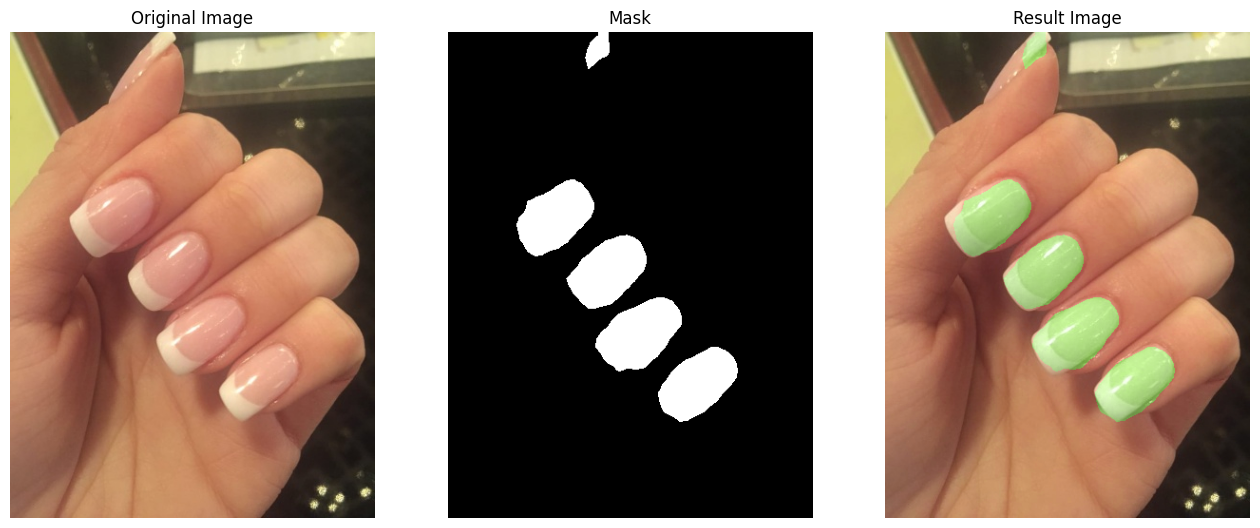

In [9]:
import paddle
import cv2
import numpy as np
import matplotlib.pyplot as plt

model = paddle.jit.load('/content/drive/MyDrive/Nails_Segementation_infer_model/infer_model/model')
model.eval()

ori_img = cv2.imread('/content/Nails/images/1eecab90-1a92-43a7-b952-0204384e1fae.jpg')

img = ori_img / 255.
img = paddle.vision.transforms.normalize(img, mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5], data_format='HWC')
img = img.transpose((2, 0, 1))
img = paddle.to_tensor(img, dtype='float32')
img = img.reshape([1] + img.shape)

pre = model(img)

mask = pre[0]
mask = mask * 255
mask = np.array(mask, np.uint8)

hsv_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2HSV)
hsv_img[mask > 0, 0] = 45
bgr_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)

fig, ax = plt.subplots(1, 3, figsize=(16, 8))
ax[0].imshow(ori_img[:, :, ::-1])
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Mask')
ax[1].axis('off')
ax[2].imshow(bgr_img)
ax[2].set_title('Result Image')
ax[2].axis('off')
plt.show()

In [ ]:
!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 120.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 13.4 MB/s eta 0:00:00


## Gradio 실시간 데모

- L4에서는 속도가 느림 ㅠㅠ

In [ ]:
import gradio as gr

def resize_with_aspect_ratio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)

def process_frame(frame):
    frame = resize_with_aspect_ratio(frame, width=640)

    # 이미지 전처리
    img = frame / 255.
    img = paddle.vision.transforms.normalize(img, mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5], data_format='HWC')
    img = img.transpose((2, 0, 1))
    img = paddle.to_tensor(img, dtype='float32')
    img = img.reshape([1] + img.shape)

    # 인퍼런스
    pre = model(img)

    # 마스크 생성
    mask = pre[0]
    mask = mask * 255
    mask = np.array(mask, np.uint8)

    # 색상 변경
    hsv_img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    hsv_img[mask > 0, 0] = 45
    bgr_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR)

    return bgr_img

def webcam_inference(input_frame):
    # BGR에서 RGB로 변환 (Gradio는 RGB 사용)
    input_frame = cv2.cvtColor(input_frame, cv2.COLOR_RGB2BGR)

    # 프레임 처리
    output_frame = process_frame(input_frame)

    # BGR에서 RGB로 다시 변환
    output_frame = cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB)

    return output_frame

# Gradio 인터페이스 설정
iface = gr.Interface(
    fn=webcam_inference,
    inputs=gr.Image(sources=["webcam"], streaming=True),
    outputs="image",
    live=True,
)

# 실행
iface.launch(debug=True, share=True)

In [11]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.13.0
    Uninstalling tomlkit-0.13.0:
      Successfully uninstalled tomlkit-0.13.0


In [26]:
import paddle
import cv2
import numpy as np
import gradio as gr
import tempfile

def resize_with_aspect_ratio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)

def process_frame(frame):
    # 이미지 리사이즈 (최대 너비 640으로 설정)
    frame = resize_with_aspect_ratio(frame, width=640)

    # 이미지 전처리
    img = frame / 255.
    img = paddle.vision.transforms.normalize(img, mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5], data_format='HWC')
    img = img.transpose((2, 0, 1))
    img = paddle.to_tensor(img, dtype='float32')
    img = img.reshape([1] + img.shape)

    # 인퍼런스
    pre = model(img)

    # 마스크 생성
    mask = pre[0]
    mask = mask * 255
    mask = np.array(mask, np.uint8)

    # 마스크를 원본 이미지 크기로 리사이즈
    mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)

    # 색상 변경
    hsv_img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    hsv_img[mask > 0, 0] = 45
    bgr_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR)

    return bgr_img

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)

    # 임시 출력 파일 생성
    temp_output = tempfile.NamedTemporaryFile(delete=False, suffix='.mp4')
    output_path = temp_output.name
    temp_output.close()

    # 비디오 작성자 설정
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = None

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # BGR에서 RGB로 변환
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # 프레임 처리
        processed_frame = process_frame(frame_rgb)

        # RGB에서 BGR로 다시 변환
        processed_frame_bgr = cv2.cvtColor(processed_frame, cv2.COLOR_RGB2BGR)

        # 첫 프레임에서 비디오 작성자 초기화
        if out is None:
            height, width = processed_frame_bgr.shape[:2]
            out = cv2.VideoWriter(output_path, fourcc, 30.0, (width, height))

        out.write(processed_frame_bgr)

    cap.release()
    out.release()

    return output_path

# Gradio 인터페이스 설정
iface = gr.Interface(
    fn=process_video,
    inputs=gr.Video(),
    outputs=gr.Video(),
    title="네일아트 시뮬레이션 프로그램 - 유튜브 빵형의 개발도상국",
    description="비디오를 업로드하면 네일 색상이 변경된 비디오가 출력됩니다."
)

# 실행
iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://451f9017e0819bd70d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [44]:
!nvidia-smi

Tue Aug  6 18:11:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0              40W /  70W |    221MiB / 15360MiB |     39%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--